In [1]:
# imports and loading
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import sys
sys.path.insert(0, '../functions/')
import interface_GAMS as iG
import pickle

pickle_in = open('../data/b_to_gene.pkl', 'rb')
b_to_gene = pickle.load(pickle_in)
pickle_in.close()
gene_to_b = {v : k for k, v in b_to_gene.items()}

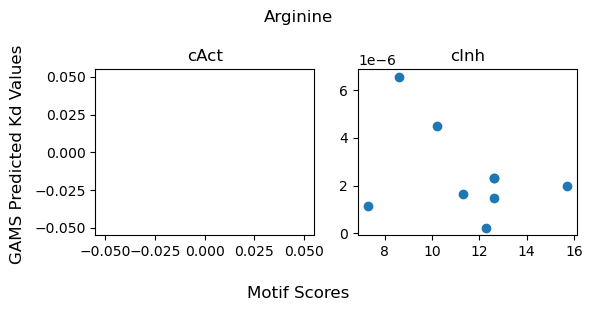

In [5]:
# plotting

# settings
case = 'Arginine'
mean_min_max = 'max' # the current model only allows one binding site for TF-gene, sometimes multiple binding sites exist, which score do you take?

# load in TF_flags dataframe
TF_flags_df = pd.read_csv('../data/TF_saved_flags.csv', index_col = 0)
true_false = []
for iM in TF_flags_df.index:
    if iM == case:
        true_false.append(True)
    else:
        true_false.append(False)
TF_flags_df = TF_flags_df.loc[true_false]


# let's find our run_dir
iter_f = 'iter_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case) if 'iter_' in f and '.pkl' not in f]))
run_f = 'run_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case+'/'+iter_f) if 'run_' in f and '.pkl' not in f]))
GAMs_run_dir = '../GAMs/optimization_runs/'+case+'/'+iter_f+'/'+run_f


if True:
    # first load in relevant info
    GAMS_calc_cAct, cAct_kd_df, act_metab_df, act_kd_metab_df, GAMS_calc_cInh, cInh_kd_df, inh_metab_df, inh_kd_metab_df = iG.read_multi_GAMs(GAMs_run_dir)
    pickle_in = open('../data/gene_to_operon_to_motif_scores.pkl', 'rb')
    gene_to_operon_to_motif_scores = pickle.load(pickle_in)
    pickle_in.close()
    pickle_in = open('../data/b_to_gene.pkl', 'rb')
    b_to_gene = pickle.load(pickle_in)
    pickle_in.close()
    gene_to_b = {v : k for k, v in b_to_gene.items()}
    gene_to_b.update({
        'yhbC' : 'b3170',
        #'sroD' : '', # not a real gene
    })
    # create operon to genes
    f = open('../data/regulonDB_files/OperonSet.txt', 'r')
    lines = f.readlines()
    f.close()
    operon_to_genes = {}
    for line in lines[38:]:
        operon = line.split('\t')[0]
        genes = line.split('\t')[5].split(',')
        operon_to_genes.update({operon : genes})
    operon_to_genes.update({
        'metY-yhbC-nusA-infB-rbfA-truB-rpsO-pnp' : ['metY', 'yhbC', 'nusA', 'infB', 'rbfA', 'truB', 'rpsO', 'pnp'],
        'metY' : ['metY'],
        'hisJQMP' : ['hisJ', 'hisQ', 'hisM', 'hisP'],
        'fabHDG' : ['fabH', 'fabD', 'fabG'],
        'glnB' : ['glnB'],
        'prs' : ['prs'],
    })

    # organize this by regulator to gene to motif scores
    cAct_mapping = pd.read_csv(GAMs_run_dir+'/input_files/cAct_mapping.csv', index_col = 0)
    cInh_mapping = pd.read_csv(GAMs_run_dir+'/input_files/cInh_mapping.csv', index_col = 0)
    reg_to_gene_to_scores = {}
    for index0, row in TF_flags_df.iterrows():
        GAMS_genes = cAct_mapping.index[cAct_mapping[index0] != 0].to_list() + cInh_mapping.index[cInh_mapping[index0] != 0].to_list()

        reg = row['TF']
        reg_to_gene_to_scores.update({reg : {}})

        for operon, motif_scores in gene_to_operon_to_motif_scores[row['gene_name'][0].upper()+row['gene_name'][1:]].items():
            if operon not in operon_to_genes:
                print(operon)
            genes = operon_to_genes[operon]
            for gene in genes:
                if gene not in gene_to_b and gene not in ['sroD']:
                    print(gene)
                    continue
                if gene in ['sroD']:
                    continue
                b_gene = gene_to_b[gene]
                if b_gene not in reg_to_gene_to_scores[reg]:
                    reg_to_gene_to_scores[reg].update({b_gene : []})
                for score in motif_scores:
                    reg_to_gene_to_scores[reg][b_gene].append(score)

        # let's look at cAct kd's
        bby_cAct_kd_df = cAct_kd_df.loc[cAct_mapping.index[cAct_mapping[index0] != 0].to_list()]
        bby_cAct_kd_df = bby_cAct_kd_df[bby_cAct_kd_df['iM'] == index0][['Val']]
        scores = []
        keep = []
        for index in bby_cAct_kd_df.index:
            try:
                if mean_min_max == 'mean':
                    to_add = np.mean(reg_to_gene_to_scores[reg][index])
                elif mean_min_max == 'min':
                    to_add = np.min(reg_to_gene_to_scores[reg][index])
                elif mean_min_max == 'max':
                    to_add = np.max(reg_to_gene_to_scores[reg][index])
                scores.append(to_add)
                keep.append(index)
            except:
                pass
        bby_cAct_kd_df = bby_cAct_kd_df.loc[keep]
        bby_cAct_kd_df['motif_scores'] = scores

        # let's look at cInh kd's
        bby_cInh_kd_df = cInh_kd_df.loc[cInh_mapping.index[cInh_mapping[index0] != 0].to_list()]
        bby_cInh_kd_df = bby_cInh_kd_df[bby_cInh_kd_df['iM'] == index0][['Val']]
        scores = []
        keep = []
        for index in bby_cInh_kd_df.index:
            try:
                if mean_min_max == 'mean':
                    to_add = np.mean(reg_to_gene_to_scores[reg][index])
                elif mean_min_max == 'min':
                    to_add = np.min(reg_to_gene_to_scores[reg][index])
                elif mean_min_max == 'max':
                    to_add = np.max(reg_to_gene_to_scores[reg][index])
                scores.append(to_add)
                keep.append(index)
            except:
                pass
        bby_cInh_kd_df = bby_cInh_kd_df.loc[keep]
        bby_cInh_kd_df['motif_scores'] = scores

        # plotting
        fig, axs = plt.subplots(1, 2, figsize = (6, 3))
        axs[0].scatter(bby_cAct_kd_df['motif_scores'], bby_cAct_kd_df['Val'])
        axs[1].scatter(bby_cInh_kd_df['motif_scores'], bby_cInh_kd_df['Val'])
        axs[0].set_title('cAct')
        axs[1].set_title('cInh')
        fig.supxlabel('Motif Scores')
        fig.supylabel('GAMS Predicted Kd Values')
        fig.suptitle(index0)
        plt.tight_layout()
        plt.savefig('../figures/GAMS_kd_vs_motif.pdf', transparent = True)
        plt.show()

In [8]:
GAMS_calc_cAct

,b2818,b3957,b3959,b0273,b3958,b3960,b4254,b3359,b3172
p1k_00103,0,0,0,0,0,0,0,0,0
p1k_00226,0,0,0,0,0,0,0,0,0
p1k_00536,0,0,0,0,0,0,0,0,0
p1k_01019,0,0,0,0,0,0,0,0,0
p1k_00127,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
p1k_00399,0,0,0,0,0,0,0,0,0
p1k_00221,0,0,0,0,0,0,0,0,0
p1k_00384,0,0,0,0,0,0,0,0,0
p1k_00552,0,0,0,0,0,0,0,0,0
